# INF8775 – Analyse et conception d’algorithmes
# TP2 – Hiver 2024

Nguyen, Huy Viet, 2136374

Some, Freddy, 1930443

Note finale :

 <u>**Date limite de remise :**</u>  27 mars 23h59 (Groupe B1), 19 mars 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition (en gris).

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time

In [2]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.    
    """
    # Create a figure and axis
    _, ax = plt.subplots()
    
    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')
    
    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)
    
    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)
    
    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)    
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    N = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [3]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

partition = readFile('Chansons/twinkle_twinkle.txt')

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [4]:
def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        _, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

In [5]:
from typing import TypeAlias

PreviousNote: TypeAlias = int
NextNote: TypeAlias = int

Transition: TypeAlias = list[PreviousNote, NextNote]

Coût Glouton : 55


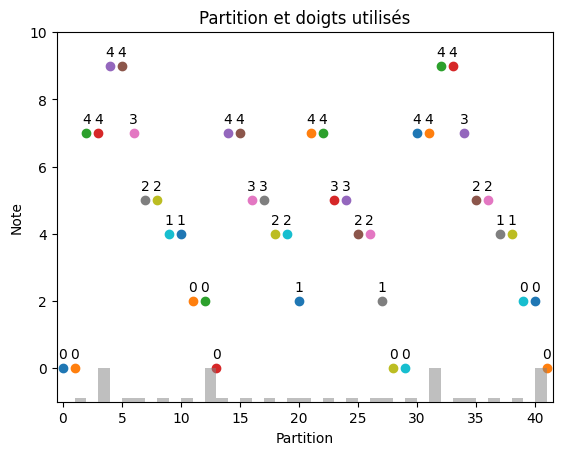

In [121]:
import itertools


# Trouve le doigt le plus optimal pour une transition
def get_next_finger(previous_finger, transition: Transition, number_of_fingers):
    next_finger = -1
    cout = 101
  
    for i in reversed(range(number_of_fingers)):  # L'itération reversed donne de meilleur résultat (à confirmer)
        cout_courant = getCosts(costs, transition, [previous_finger, i])
        if cout_courant == 0:
            next_finger = i
            break
            
        elif cout > cout_courant:
            cout = cout_courant
            next_finger = i
    
    return next_finger


def glouton(partition):
    solution = []
    
    cout = 101
    minimum = (-1, -1)

    for i, j in itertools.product(range(D), range(D)):
        cout_courant = getCosts(costs, partition[:2], [i, j])
        if cout_courant == 0:
            minimum = (i, j)
            break
        
        elif cout > cout_courant:
            cout = cout_courant
            minimum = (i, j)
              
    solution.append(minimum[0])
    solution.append(minimum[1])
    
    next_finger = -1
    for i in range(2, len(partition)):
        next_finger = get_next_finger(next_finger, [partition[i-1], partition[i]], D)
        solution.append(next_finger)

    return solution


solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

L'analyse de l'algorithme est fait pour un nombre $d$ de doigts et un nombre $k$ pour la longueur de la mélodie.

L'algorithme glouton effectue en premier la recherche de la première transition la plus optimale. Cette recherche s'arrête lorsque toutes les transitions possibles ont été évaluées ou lorsqu'une transition dont le coût est nul est trouvée. Il est donc possible que la recherche va itérer, dans le meilleur cas, sur une seule transition ou, dans le pire cas, toutes les transitions possibles ($d^2$ au total). Par conséquent, on peut déduire que la complexité de la recherche de la première transition optimale est en $\Omega(1)$ et en $O(d^2)$.

Ensuite, on itère sur le reste de la mélodie pour trouver le doigt à jouer pour les prochaines notes en appelant la fonction get_next_finger à chaque itération. La fonction get_next_finger fait une boucle sur tous les doigts pour trouver lequel d'entre eux permet d'avoir la transition avec le plus petit coût, la boucle s'arrête lorsqu'on trouve une transition avec un coût nul ou lorsqu'on a finit d'itérer sur les $d$ doigts possibles. Puisque la fonction getCosts, qui est appelé à chaque itération de la boucle, est en $\Theta(1)$ parce qu'on l'appelle toujours avec la même taille d'exemplaire, on peut déduire que chaque itération de la boucle est en $\Theta(1)$. Alors, on déduit que la complexité de la boucle est en $\Omega(1)$ et en $O(d)$. Donc, la complexité de la fonction est get_next_finger en $\Omega(1)$ et en $O(d)$. La recherche des prochaines notes après la première transition se fait donc en $k \times \Omega(1) = \Omega(k)$ et en $k \times O(d) = O(kd).$

En conclusion, la complexité de l'algorithme est en $\Omega(1) + \Omega(k) = \Omega(k)$ et en $O(d^2) + O(kd) = O(d^2 + kd)$. On remarque que le temps de calcul croit linéairement en fonction de $k$ et croit de manière quadratique en fonction de $d$. Ceci permet de déduire que, lorsque la valeur de $d$ est fixée, la complexité de l'algorithme est en $\Theta(k)$, et que, lorsque la valeur de $k$ est fixée, la complexité de l'algorithme est en $\Omega(1)$ et en $O(d^2)$.

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [117]:
dataset = get_dataset(2136374, [1600, 3200, 6400, 12800, 25600, 51200, 80000, 102400, 150000, 204800])
D = 5  # On effectue les messures avec les 5 doigts

In [8]:
mesures_glouton = measure_procedure(glouton, dataset)

In [9]:
display_measures_table(mesures_glouton)

Taille       Temps moyen (s)
1600         0.07517623901367188
3200         0.16257929801940918
6400         0.33163952827453613
12800        0.5942718029022217
25600        1.2545604705810547
51200        2.4698611736297607
80000        3.8153429508209227
102400       5.005062103271484
150000       7.089771556854248
204800       10.299084138870239


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

Pour faciliter la validation, une analyse sera effectuée pour des longueurs de mélodie qui varient et un nombre de doigts constant, et une autre sera effectuée pour une longueur de mélodie constante et un nombre de doigts qui varie entre 1 et 5.

### Temps d'exécution en fonction de la longueur de la mélodie $k$

#### Test de puissance

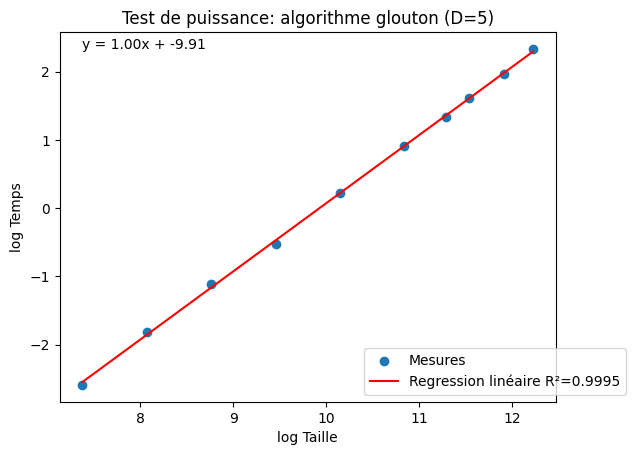

In [10]:
import math

def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs x:y pour le test de puissance
        math.log(x) : math.log(y) for x, y in measures.items() 
    }

display_test_puissance(values_test_puissance(mesures_glouton), "Test de puissance: algorithme glouton (D=5)")

On remarque que les points suivent de près la forme d'une droite valeur, ce qui semble indiquer que la croissance du temps de calcul de l'algorithme glouton est polynomiale. De plus, puisque la pente et l'ordonnée à l'origine sont respectivement 1,01 et -10,08 ; on peut déduire que le temps de calcul de l'algorithme semble suivre l'équation $y = e^{-10,08} \times x^{1,01}$. On peut ainsi remarquer que la pente se situe autour de 1, ce qui semble indiquer que la complexité de l'algorithme devrait se situer autour de $\Theta (k)$, où k est la longueur de la mélodie.

#### Test du rapport

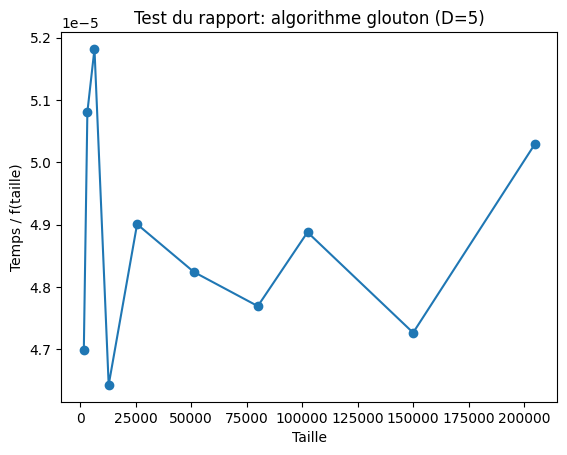

In [11]:
def values_test_rapport(measures, f):
    return { x : y / f(x) for x, y in measures.items() }

def f(x):
    return x

display_test_rapport(values_test_rapport(mesures_glouton, f), "Test du rapport: algorithme glouton (D=5)")

Puisque l'algorithme glouton semble croître linéairement en fonction de la longueur de la mélodie pour un nombre de doigts fixé, la fonction $f(x) = x$ permettrait donc de confirmer que la croissance de l'algorithme en fonction de la longueur de la mélodie pour un nombre de doigts fixé est réellement linéaire.

#### Test des constantes

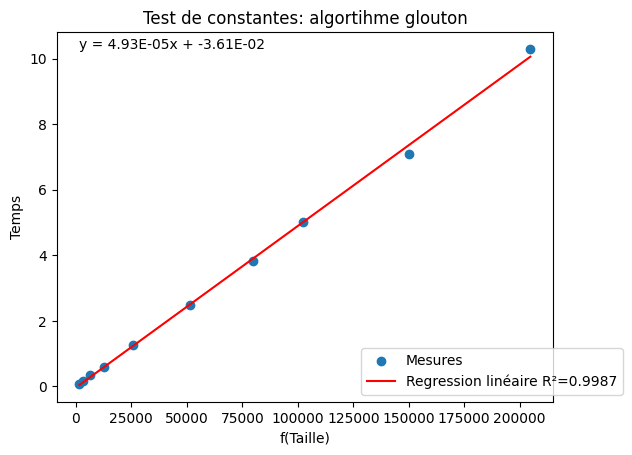

In [12]:
def values_test_constantes(measures, f):
    return { f(x) : y for x, y in measures.items() }

def f(x):
    return x

display_test_constantes(values_test_constantes(mesures_glouton, f), "Test de constantes: algortihme glouton")

### Temps d'exécution en fonction du nombre de doigts $d$

La difficulté pour l'analyse empyrique est que les tailles d'exemplaires de $d$ sont très limitées et petites, ce qui rend les résultats très susceptible au bruit. Une solution pour contrer en partie le bruit serait d'augmenter le nombre de mesures prises. Une autre considération est que, puisque la complexité de l'algorithme glouton est en $O(d^2 + dk)$, la longueur choisie de la mélodie va influencer la complexité observé. Si la mélodie est beaucoup plus long que le nombre de doigts, alors $dk > d^2$ et on aura une complexité en $O(dk)$. Si la longueur de la mélodie est plus petite que le nombre de doigts, alors $dk < d^2$ et on aura une complexité en $O(d^2)$.

L'analyse va étudier trois cas : le meilleur cas pour une mélodie de 2000, le cas où la longueur de la mélodie est de 400 et le cas où la longueur de la mélodie est de 2.

#### Meilleur cas (k=2000)

Le meilleur cas est rare parce qu'il faut que l'algorithme glouton choisisse à chaque fois une transition avec un coût de 0. Un tel cas est lorsque c'est la même note qui est joué à chaque fois, ce qui arrive seulement si on doit joue de doigt 1 pour chaque note.

In [130]:
D = 5

samples = [[5] * 2000 for _ in range(10)]

In [131]:
D = 1
mesures_glouton = {}
while D <= 5:
    mesures_glouton[D] = measure_mean_time(glouton, samples)
    D += 1

In [132]:
display_measures_table(mesures_glouton)

Taille       Temps moyen (s)
1            0.01806635856628418
2            0.016903328895568847
3            0.017005109786987306
4            0.01814122200012207
5            0.017385530471801757


#### Cas mélodie de 400 notes

#### Cas mélodie de 2 notes

La complexité $O(d^2)$ de l'algorithme en fonction du nombre de doigts pour une longueur de mélodie fixée est issue de la recherche de la première transition optimale. En général, pour des humains, le nombre de doigts est beaucoup plus petit que 

In [122]:
samples = [generate_sample(2) for _ in range(15000)]

In [125]:
D = 1
mesures_glouton = {}
while D <= 5:
    mesures_glouton[D] = measure_mean_time(glouton, samples)
    D += 1

D = 5

In [126]:
display_measures_table(mesures_glouton)

Taille       Temps moyen (s)
1            1.3319555918375651e-05
2            3.947602907816569e-05
3            8.271382649739584e-05
4            0.0001617935021718343
5            0.00023219013214111328


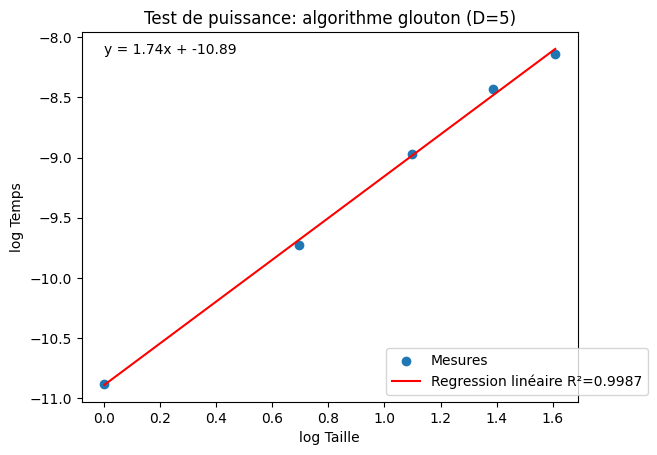

In [63]:
import math

def values_test_puissance(measures):
    return { math.log(x) : math.log(y) for x, y in measures.items() }

display_test_puissance(values_test_puissance(mesures_glouton), "Test de puissance: algorithme glouton (D=5)")

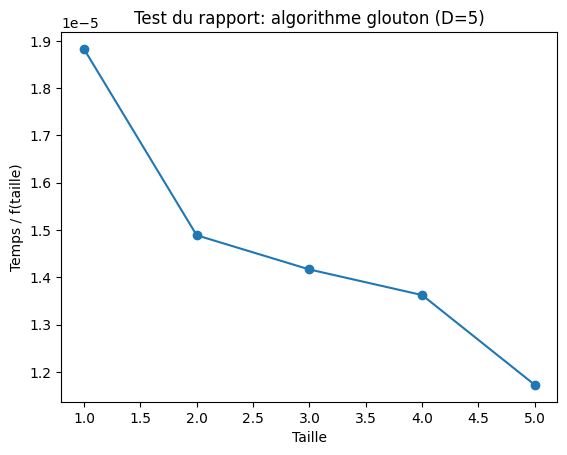

In [67]:
def values_test_rapport(measures, f):
    return { x : y / f(x) for x, y in measures.items() }

def f(x):
    return (x ** 2)

display_test_rapport(values_test_rapport(mesures_glouton, f), "Test du rapport: algorithme glouton (D=5)")

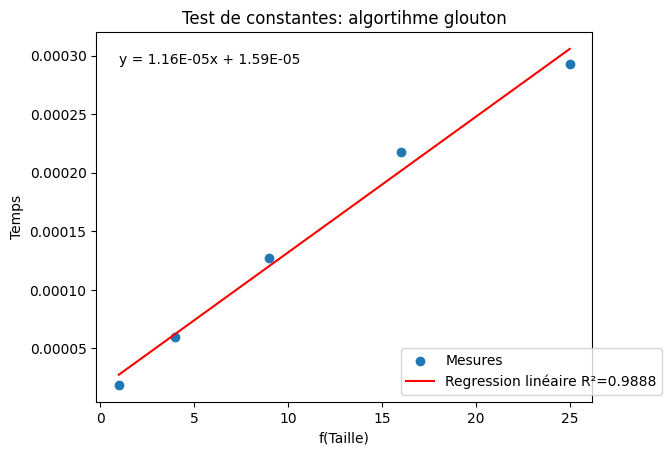

In [68]:
def values_test_constantes(measures, f):
    return { f(x) : y for x, y in measures.items() }

def f(x):
    return x ** 2

display_test_constantes(values_test_constantes(mesures_glouton, f), "Test de constantes: algortihme glouton")

## Partie 2 : Algorithme de programmation dynamique

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

In [17]:
def progDyn(partition):
    n = len(partition)
    solution_costs = [[0] * n for _ in range(D)]
    
    min = (-1, 100)
    for 
    
    solution = [0 for i in range(len(partition))]
    return solution

solutionDyn = progDyn(partition)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

SyntaxError: invalid syntax (3286792347.py, line 6)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

*Insérer votre réponse ici*

## Partie 3 : Algorithme de recherche locale

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

In [ ]:
def localSearch(partition):
    solution = [0 for i in range(len(partition))]
    return solution

solutionLocal = localSearch(partition)
print("Coût Recherche Locale :", getTotalCost(costs, partition, solutionLocal))
visualize_solution(costs, partition, solutionLocal)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

*Insérer votre réponse ici*

# Conclusion et synthèse

Résumez succintement vos résultats et indiquez sous quelles conditions vous utiliseriez chacun des algorithmes.

*Insérer votre réponse ici*